# UDLF Non-Local Means (RL-RECOM)
Images and data collected from experiments of UDLF Non-Local Means with RL-RECOM as the reranking method used.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

%matplotlib inline

from skimage import data
from skimage.color import rgb2gray
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.restoration import estimate_sigma
from skimage.util import random_noise

from nlmeans.nlmeans import nlmeans
from nlmeans.nlmeans_udlf import nlmeans_udlf

## Parameters

In [2]:
# Non-Local Means parameters
hW = 10        # Window Size
hP = 3         # Patch Size
tau = 0.15     # Contribution of similarity on noisy-data
sig = 0.1      # Standard deviation of the gaussian noise
shape = 'disk' # Patch shape
n_w = None     # Number of weights to use or use all(None)

# Image to test with
image = 'astronaut'

# UDLF Parameters
udl_method = 'RLRECOM'
udl_params = {
    'k': 8,
    'lambda': 2,
    'epsilon': 0.0125
}

## Auxiliary
Auxiliary snippets of code used troughout this notebook.

### Remove temporary files
Auxiliar function used to remove the temporary files created by UDLF.

In [3]:
def rm_tmp_files():
    tmp_files = ['input.txt', 'list.txt', 'log.txt', 'output.txt']
    for tmp_file in tmp_files:
        try:
            os.remove(tmp_file)
        except FileNotFoundError:
            pass
        
rm_tmp_files()

### Center the output of the cells
Based on [this](https://stackoverflow.com/a/45708384) Stack Overflow answer. (Not being used at the moment)

In [4]:
%%script echo skipping
from IPython.display import display, HTML

display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

skipping


## Image preprocessing
Get the image from skimage dataset or use the image from the local file system if not found in skimage. 

After that, do the necessary preprocessing:
- Crop the image to be 200x200 (This is necessary because UDLF has to be able to allocate memory to process the 
  ranked lists gotten from the image. In a system with more memory the image can possibly be greater);
- Convert the image from RGB to Grayscale.

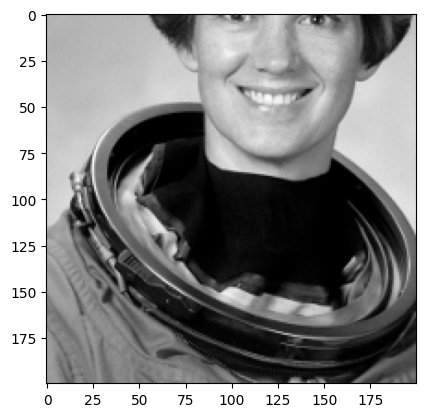

In [5]:
images = ['astronaut',
          'binary_blobs',
          'colorwheel',
          'cat',
          'coffee',
          'eagle',
          'horse',
          'logo',
          'page',
          'text',
          'rocket',
         ]

if image in images:
    im = getattr(data, image)()
    im = im[100:300, 100:300]
    #im = im[0:200, 0:200]
    im_name = image
else:
    im = plt.imread(image).astype('float')
    im_name = os.path.splitext(os.path.basename(image))[0]

if len(im.shape) == 3:
    im = rgb2gray(im)

# Show the image
plt.imshow(im, cmap='gray')

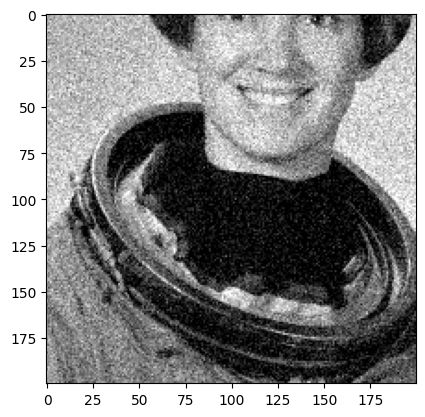

In [6]:
im_nse = random_noise(im, var = sig**2)
sigma_est = np.mean(estimate_sigma(im_nse, channel_axis=-1))
plt.imshow(im_nse, cmap='gray')

## Non-Local Means SAP
For comparison the Non-Local Means SAP (the algorithm on which UDLF Non-Local Means is based) is run as well. 

CPU times: user 1.48 s, sys: 6.77 ms, total: 1.49 s
Wall time: 1.49 s


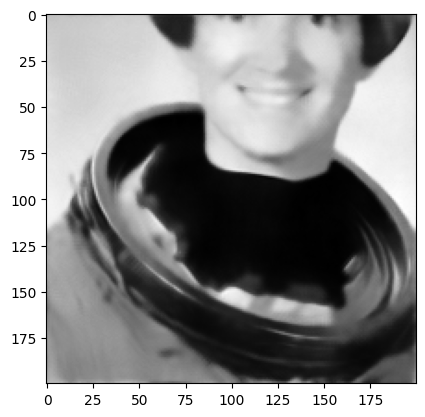

In [7]:
%%time
im_fil1 = nlmeans(im_nse, hW, hP, tau, sigma_est, shape)
plt.imshow(im_fil1, cmap='gray')

## UDLF Non-Local Means (NONE)
The results of the reranking method will be compared with Non-Local Means using the original ranked lists, that is, the ranked lists used as input to UDLF. 

CPU times: user 15.6 s, sys: 718 ms, total: 16.3 s
Wall time: 16.3 s


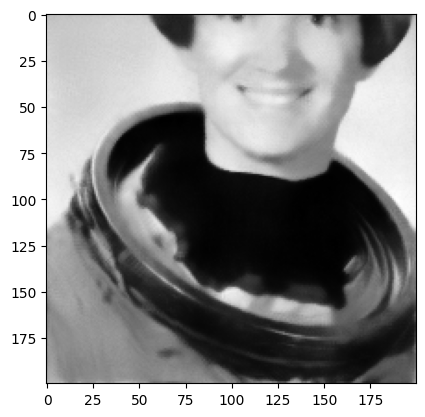

In [8]:
%%time
im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, 'NONE', None, n_w)
rm_tmp_files()
plt.imshow(im_fil3, cmap='gray')

## UDLF Non-Local Means (RL-RECOM)
This denoise the image using RL-RECOM as the reranking method and considering RLRECOM default parameters as indicated in the [UDLF config.ini](https://github.com/UDLF/UDLF/blob/master/bin/config.ini)

CPU times: user 16.8 s, sys: 957 ms, total: 17.8 s
Wall time: 30.8 s


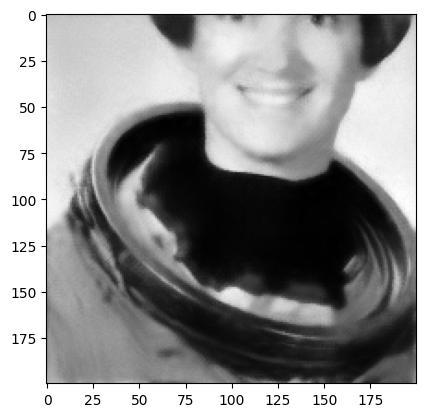

In [9]:
%%time
im_fil2 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
rm_tmp_files()
plt.imshow(im_fil2, cmap='gray')

### Show the images side by side

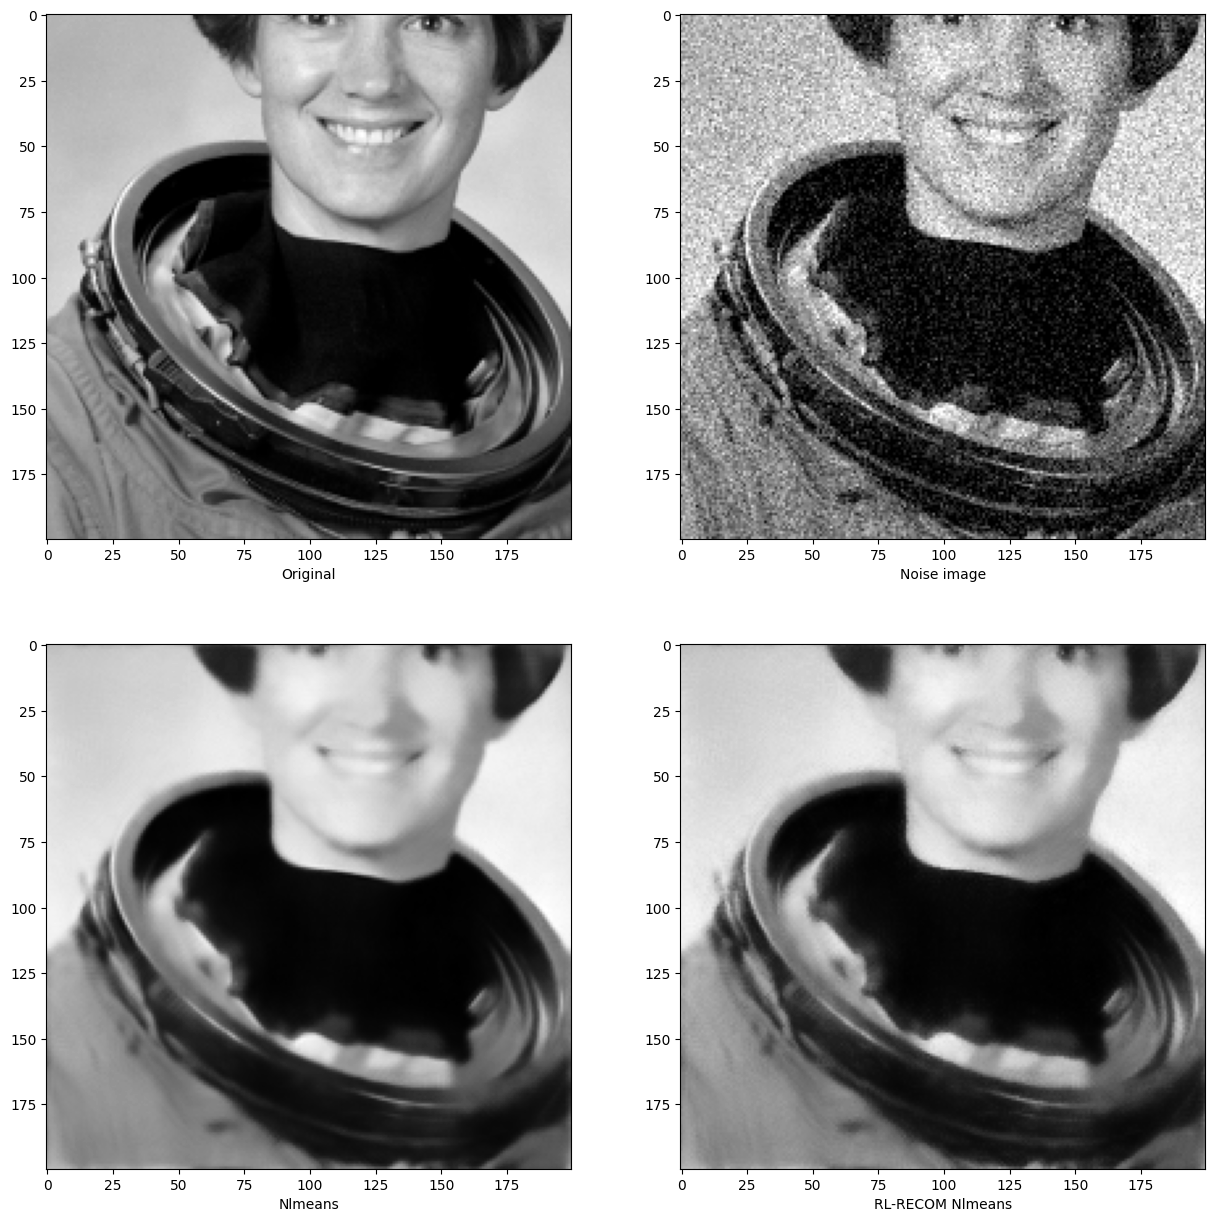

,Noise,Nlmeans,RL-RECOM Nlmeans,NONE Nlmeans
PSNR,20.590361,23.274648,23.322871,23.483695
SSIM,0.451253,0.681128,0.685605,0.688790
MSE,0.008729,0.003361,0.003311,0.003241


In [10]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.figure()
plt.subplot(2, 2, 1)
plt.xlabel('Original')
plt.imshow(im, cmap='gray')
plt.subplot(2, 2, 2)
plt.xlabel('Noise image')
plt.imshow(im_nse, cmap='gray')
plt.subplot(2, 2, 3)
plt.xlabel('Nlmeans')
plt.imshow(im_fil1, cmap='gray')
plt.subplot(2, 2, 4)
plt.xlabel('RL-RECOM Nlmeans')
plt.imshow(im_fil2, cmap='gray')
plt.show()

im_noise_psnr = psnr(im, im_nse, data_range=im_nse.max() - im_nse.min())
im_noise_ssim = ssim(im, im_nse, data_range=im_nse.max() - im_nse.min())
im_noise_mse  = mse(im, im_nse)

im_nlm_psnr   = psnr(im, im_fil1, data_range=im_fil1.max() - im_fil1.min())
im_nlm_ssim   = ssim(im, im_fil1, data_range=im_fil1.max() - im_fil1.min())
im_nlm_mse    = mse(im, im_fil1)

im_udlf_psnr  = psnr(im, im_fil2, data_range=im_fil2.max() - im_fil2.min())
im_udlf_ssim  = ssim(im, im_fil2, data_range=im_fil2.max() - im_fil2.min())
im_udlf_mse   = mse(im, im_fil2)

im_none_psnr  = psnr(im, im_fil3, data_range=im_fil3.max() - im_fil3.min())
im_none_ssim  = ssim(im, im_fil3, data_range=im_fil3.max() - im_fil3.min())
im_none_mse   = mse(im, im_fil3)

# Updates the figure size
plt.rcParams['figure.figsize'] = [15, 5]

pd.DataFrame(
    data   = np.array([[im_noise_psnr, im_nlm_psnr, im_udlf_psnr, im_none_psnr],
                       [im_noise_ssim, im_nlm_ssim, im_udlf_ssim, im_none_ssim],
                       [im_noise_mse,  im_nlm_mse,  im_udlf_mse,  im_none_mse]]),
    index   = ['PSNR', 'SSIM', 'MSE'],
    columns = ['Noise', 'Nlmeans', 'RL-RECOM Nlmeans', 'NONE Nlmeans'],
)

## Hyperparameters Tuning
The last experiment was runned using the default parameters which can be not the best. The next section tries to find the best value to each of the parameters accepted by the reranking method.

All the tests will be made considering PSNR as the value to be maximized.

The parameters found for the first image will be used for the experiments in all the other images.

### K

In [11]:
%%time
# For speed porpuses only a subset of the values accepted by k will be tested (testing all the possible values for k
# could spend up to 80 hours).
start    = 3
end      = 21
step     = 1
possible_values = range(start, end, step)
iter_num = len(possible_values)
psnrs    = np.zeros(iter_num)
psnr_max = 0
best_k   = 0
best_im  = None

for i, k in enumerate(possible_values):
    udl_params['k'] = k
    try:
        im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
        rm_tmp_files()
        psnr_value = psnr(im, im_fil3, data_range=im_fil3.max() - im_fil3.min())
        if psnr_value > psnr_max:
            psnr_max = psnr_value
            best_k   = k
            best_im  = im_fil3
        psnrs[i] = psnr_value
    except:
        print('Finished with error on param:', k)
        break
        
# Update method parameters
udl_params['k'] = best_k
print('params:', udl_params)
print('PSNR:', psnr_max)

params: {'k': 3, 'lambda': 2, 'epsilon': 0.0125}
PSNR: 23.35778028132507
CPU times: user 5min 16s, sys: 14.6 s, total: 5min 31s
Wall time: 11min 15s


Text(0, 0.5, 'PSNR')

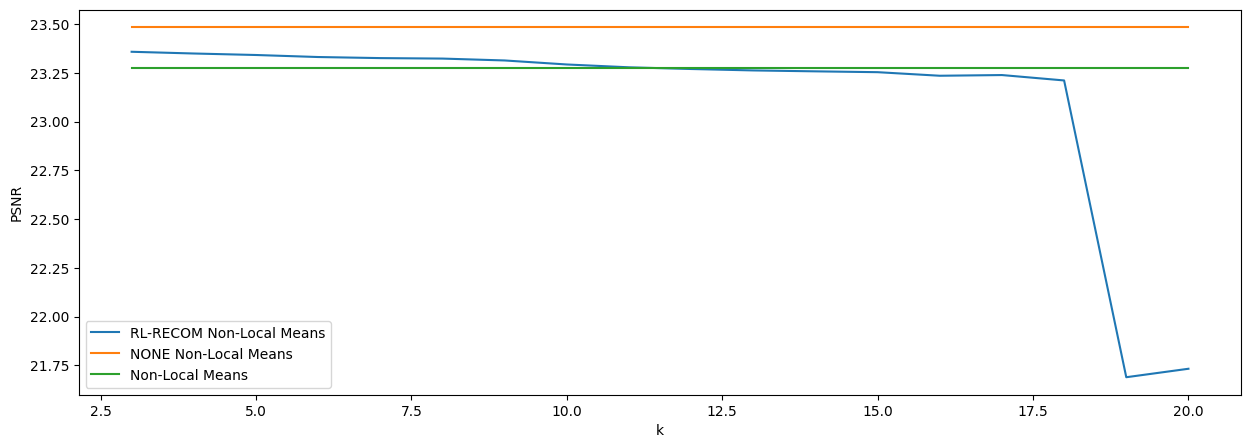

In [12]:
udlf_plot, = plt.plot(possible_values, psnrs, label = 'RL-RECOM Non-Local Means')
none_plot, = plt.plot(possible_values, [im_none_psnr] * iter_num, label = 'NONE Non-Local Means')
nlm_plot,  = plt.plot(possible_values, [im_nlm_psnr] * iter_num, label = 'Non-Local Means')
plt.legend(handles = [udlf_plot, none_plot, nlm_plot])
plt.xlabel('k')
plt.ylabel('PSNR')

### Lambda

In [13]:
%%time
start    = 2
end      = 21
step     = 1
possible_values = range(start, end, step)
iter_num = len(possible_values)
psnrs    = np.zeros(iter_num)
best_lbd = udl_params['lambda']

for i, lbd in enumerate(possible_values):
    udl_params['lambda'] = lbd
    try:
        im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
        rm_tmp_files()
        psnr_value = psnr(im, im_fil3, data_range=im_fil3.max() - im_fil3.min())
        if psnr_value > psnr_max:
            psnr_max = psnr_value
            best_lbd = lbd
            best_im  = im_fil3
        psnrs[i] = psnr_value
    except:
        print('Finished with error on param:', k)
        break
        
# Update method parameters
udl_params['lambda'] = best_lbd
print('params:', udl_params)
print('PSNR:', psnr_max)

params: {'k': 3, 'lambda': 9, 'epsilon': 0.0125}
PSNR: 23.36069591090417
CPU times: user 5min 38s, sys: 14.9 s, total: 5min 53s
Wall time: 10min 8s


Text(0, 0.5, 'PSNR')

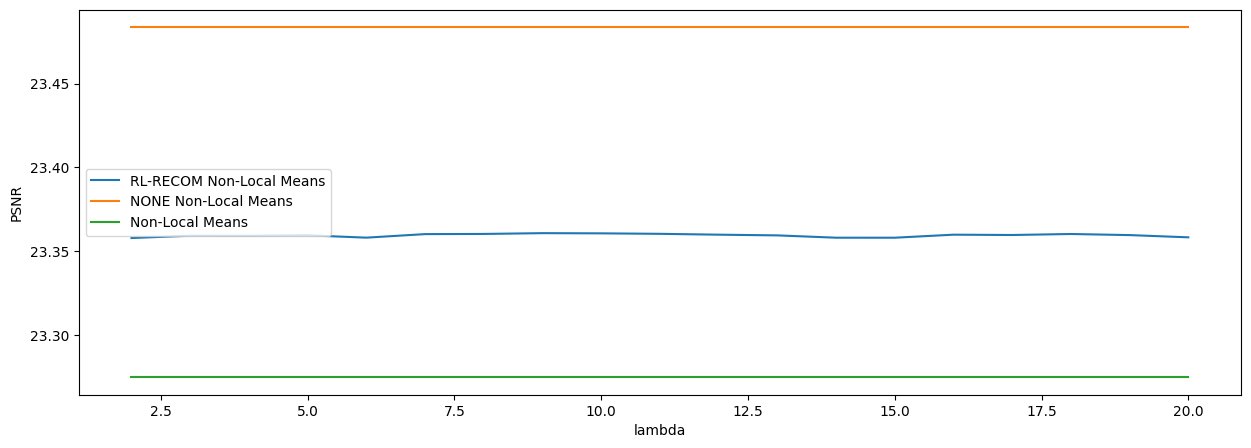

In [14]:
udlf_plot, = plt.plot(possible_values, psnrs, label = 'RL-RECOM Non-Local Means')
none_plot, = plt.plot(possible_values, [im_none_psnr] * iter_num, label = 'NONE Non-Local Means')
nlm_plot,  = plt.plot(possible_values, [im_nlm_psnr] * iter_num, label = 'Non-Local Means')
plt.legend(handles = [udlf_plot, none_plot, nlm_plot])
plt.xlabel('lambda')
plt.ylabel('PSNR')

### Epsilon

In [15]:
%%time
start    = udl_params['epsilon']
end      = 0.05
step     = 0.002
possible_values = np.arange(start, end, step)
iter_num = len(possible_values)
psnrs    = np.zeros(int(iter_num))
best_eps = udl_params['epsilon']

for i, eps in enumerate(possible_values):
    udl_params['epsilon'] = eps
    try:
        im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
        rm_tmp_files()
        psnr_value = psnr(im, im_fil3, data_range=im_fil3.max() - im_fil3.min())
        if psnr_value > psnr_max:
            psnr_max = psnr_value
            best_eps = eps
            best_im  = im_fil3
        psnrs[i] = psnr_value
    except:
        print('Finished with error on param:', k)
        break
        
# Update method parameters
udl_params['epsilon'] = best_eps
print('params:', udl_params)
print('PSNR:', psnr_max)

params: {'k': 3, 'lambda': 9, 'epsilon': 0.0125}
PSNR: 23.36069591090417
CPU times: user 5min 49s, sys: 15.1 s, total: 6min 4s
Wall time: 10min 21s


Text(0, 0.5, 'PSNR')

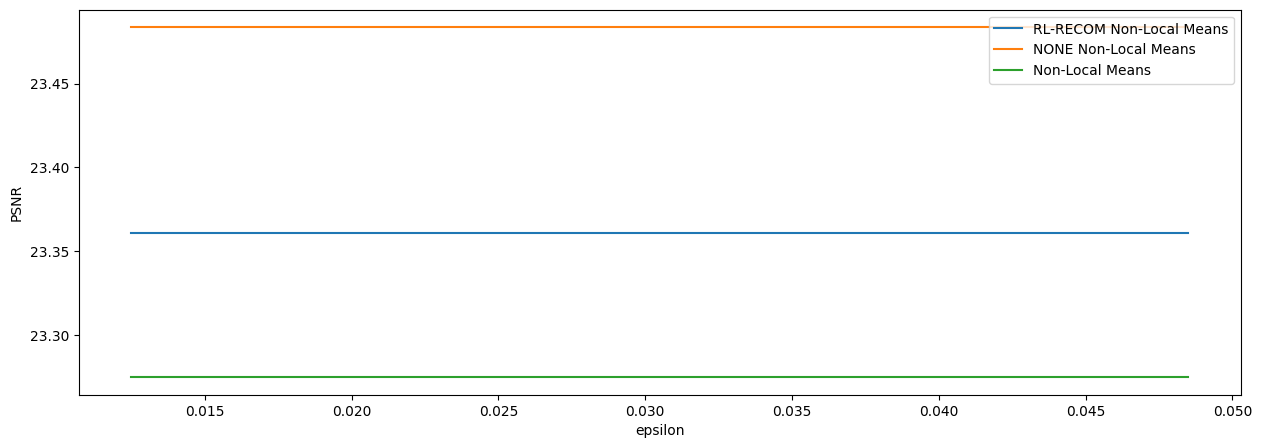

In [16]:
udlf_plot, = plt.plot(possible_values, psnrs, label = 'RL-RECOM Non-Local Means')
none_plot, = plt.plot(possible_values, [im_none_psnr] * iter_num, label = 'NONE Non-Local Means')
nlm_plot,  = plt.plot(possible_values, [im_nlm_psnr] * int(iter_num), label = 'Non-Local Means')
plt.legend(handles = [udlf_plot, none_plot, nlm_plot])
plt.xlabel('epsilon')
plt.ylabel('PSNR')

### Final Result

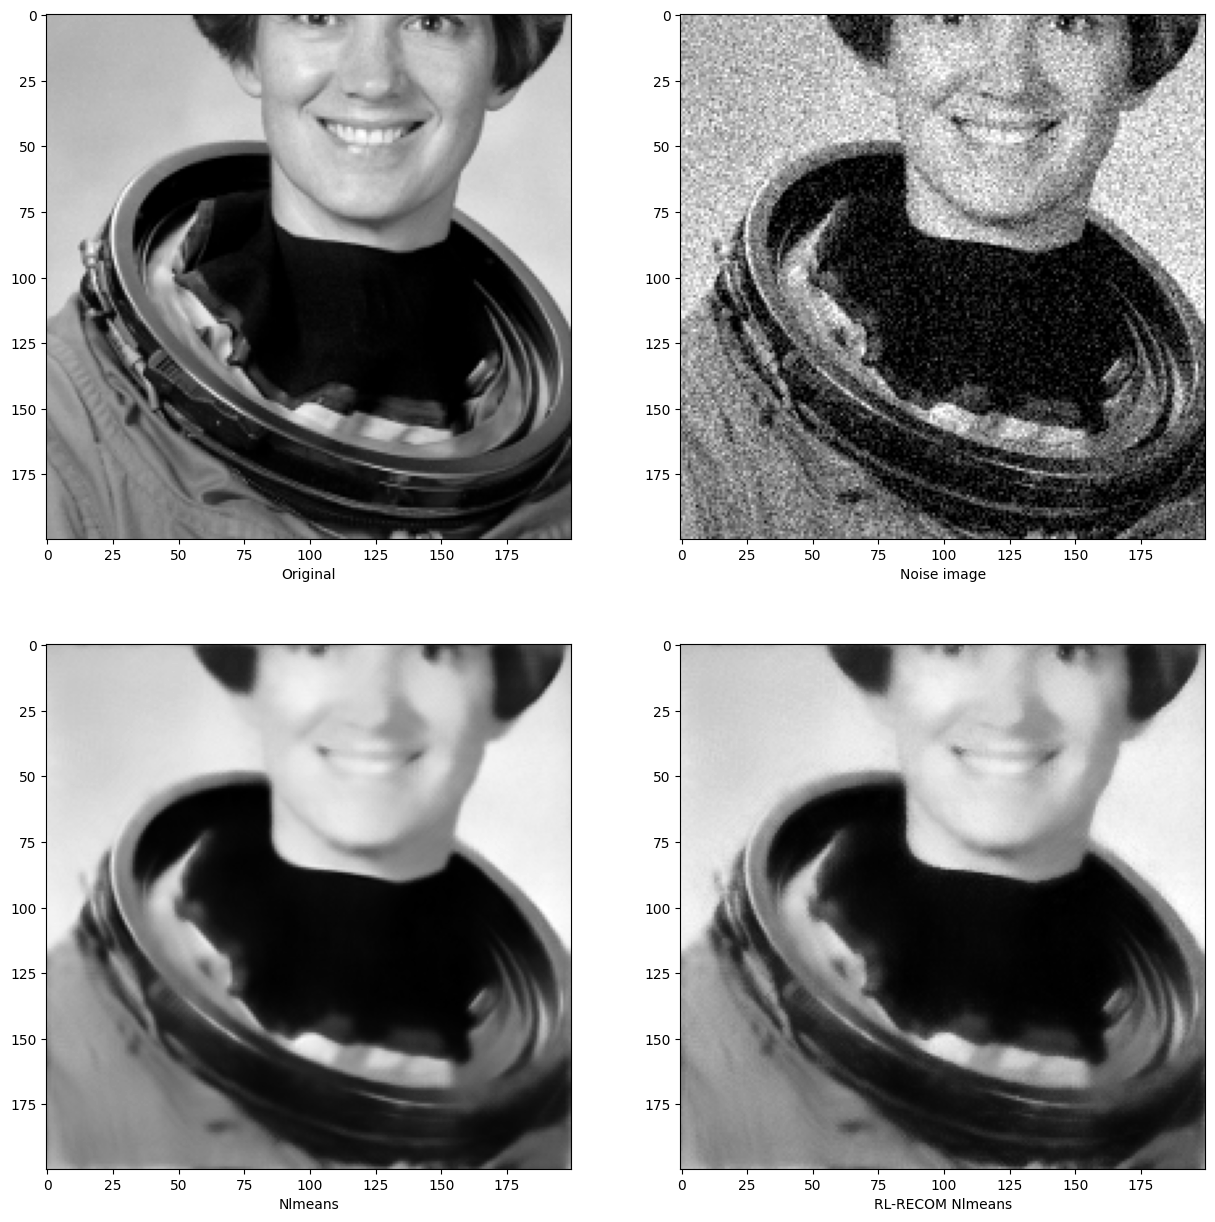

,Noise,Nlmeans,RL-RECOM Nlmeans,NONE Nlmeans
PSNR,20.590361,23.274648,23.360696,23.483695
SSIM,0.451253,0.681128,0.686489,0.688790
MSE,0.008729,0.003361,0.003278,0.003241


In [17]:
im_fil2 = best_im

plt.rcParams['figure.figsize'] = [15, 15]
plt.figure()
plt.subplot(2, 2, 1)
plt.xlabel('Original')
plt.imshow(im, cmap='gray')
plt.subplot(2, 2, 2)
plt.xlabel('Noise image')
plt.imshow(im_nse, cmap='gray')
plt.subplot(2, 2, 3)
plt.xlabel('Nlmeans')
plt.imshow(im_fil1, cmap='gray')
plt.subplot(2, 2, 4)
plt.xlabel('RL-RECOM Nlmeans')
plt.imshow(best_im, cmap='gray')
plt.show()

# Updates the figsize
plt.rcParams['figure.figsize'] = [15, 5]

# Recalculates for UDLF
im_udlf_psnr  = psnr(im, im_fil2, data_range=im_fil2.max() - im_fil2.min())
im_udlf_ssim  = ssim(im, im_fil2, data_range=im_fil2.max() - im_fil2.min())
im_udlf_mse   = mse(im, im_fil2)

pd.DataFrame(
    data   = np.array([[im_noise_psnr, im_nlm_psnr, im_udlf_psnr, im_none_psnr],
                       [im_noise_ssim, im_nlm_ssim, im_udlf_ssim, im_none_ssim],
                       [im_noise_mse,  im_nlm_mse,  im_udlf_mse,  im_none_mse]]),
    index   = ['PSNR', 'SSIM', 'MSE'],
    columns = ['Noise', 'Nlmeans', 'RL-RECOM Nlmeans', 'NONE Nlmeans'],
)

## Experiments with other images
Given the images tuple containing a subset of the images in skimage.data, denoise will be made in all these images to compare in the end if the UDLF Non-Local Means algorithm was positive in all of them. 

In [18]:
%%time
import sys

eval_info = []
eval_psnr = []
images_tested = []
print('Method:', udl_method)
print('Parameters:', udl_params)

for image in images:
    # Preprocessing
    try:
        im = getattr(data, image)()
    except ModuleNotFoundError:
        print('[err] Could not run test for image:', image, file=sys.stderr)
        continue
    
    # Cuts the image to be a square image with 200x200 pixels max
    if im.shape[0] > 200:
        if im.shape[1] < 200:
            im = im[0:im.shape[1], :]
        else:
            im = im[0:200, :]
    
    if im.shape[1] > 200:
        if im.shape[0] < 200:
            im = im[:, 0:im.shape[0]]
        else:
            im = im[:, 0:200]
        
    if im.shape[0] != im.shape[1]:
        print('[err] Invalid Shape on image:', image, im.shape, file=sys.stderr)
        continue
    
    try:
        if len(im.shape) == 3:
            im = rgb2gray(im)
    except ValueError:
        print('[err]rgb2gray on image:', image, im.shape, file=sys.stderr)
        continue
    
    # Add noise
    im_nse = random_noise(im, var = sig**2)
    sigma_est = np.mean(estimate_sigma(im_nse, channel_axis=-1))
    
    ## Nlmeans
    im_fil1 = nlmeans(im_nse, hW, hP, tau, sigma_est, shape)

    ## UDLF Nlmeans
    im_fil2 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
    rm_tmp_files()
    
    ## NONE Nlmeans
    im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, 'NONE', None, n_w)
    rm_tmp_files() 

    # Evaluation
    im_noise_psnr = psnr(im, im_nse, data_range=im_nse.max() - im_nse.min())
    im_noise_ssim = ssim(im, im_nse, data_range=im_nse.max() - im_nse.min())
    im_noise_mse  = mse(im, im_nse)

    im_nlm_psnr   = psnr(im, im_fil1, data_range=im_fil1.max() - im_fil1.min())
    im_nlm_ssim   = ssim(im, im_fil1, data_range=im_fil1.max() - im_fil1.min())
    im_nlm_mse    = mse(im, im_fil1)

    im_udlf_psnr  = psnr(im, im_fil2, data_range=im_fil2.max() - im_fil2.min())
    im_udlf_ssim  = ssim(im, im_fil2, data_range=im_fil2.max() - im_fil2.min())
    im_udlf_mse   = mse(im, im_fil2)
    
    im_none_psnr  = psnr(im, im_fil3, data_range=im_fil3.max() - im_fil3.min())
    im_none_ssim  = ssim(im, im_fil3, data_range=im_fil3.max() - im_fil3.min())
    im_none_mse   = mse(im, im_fil3)

    eval_info.append([im_noise_psnr, im_noise_ssim, im_noise_mse,
                      im_nlm_psnr, im_nlm_ssim, im_nlm_mse,
                      im_udlf_psnr, im_udlf_ssim, im_udlf_mse,
                      im_none_psnr, im_none_ssim, im_none_mse])
    
    eval_psnr.append([im_noise_psnr, im_nlm_psnr, im_udlf_psnr, im_none_psnr])
    
    images_tested.append(image)
    print('Tested with image:', image, im.shape)

Method: RLRECOM
Parameters: {'k': 3, 'lambda': 9, 'epsilon': 0.0125}
Tested with image: astronaut (200, 200)
Tested with image: binary_blobs (200, 200)
Tested with image: colorwheel (200, 200)
Tested with image: cat (200, 200)
Tested with image: coffee (200, 200)
Tested with image: eagle (200, 200)
Tested with image: horse (200, 200)


[err]rgb2gray on image: logo (200, 200, 4)


Tested with image: page (191, 191)
Tested with image: text (172, 172)
Tested with image: rocket (200, 200)
CPU times: user 6min 14s, sys: 14.5 s, total: 6min 28s
Wall time: 8min 37s


### Show the results

In [19]:
pd.DataFrame(
    data = eval_psnr,
    index = images_tested,
    columns = ['Noise', 'Nlmeans', 'RL-RECOM', 'NONE']
)

#pd.DataFrame(
#    data    = eval_info,
#    index   = images,
#    columns = ['PSNR Noise', 'SSIM Noise', 'MSE Noise', 
#               'PSNR Nlmeans', 'SSIM Nlmeans', 'MSE Nlmeans',
#               'PSNR RL-RECOM Nlmeans', 'SSIM RL-RECOM Nlmeans', 'MSE RL-RECOM Nlmeans',
#               'PSNR NONE Nlmeans', 'SSIM NONE Nlmeans', 'MSE NONE Nlmeans']
#)

,Noise,Nlmeans,RL-RECOM,NONE
astronaut,20.423836,27.095958,26.729569,26.910614
binary_blobs,23.030229,27.087689,27.045530,27.303270
colorwheel,21.141486,32.221854,31.589783,31.895358
cat,20.085322,23.739008,24.056660,24.017223
coffee,20.328005,25.326281,25.025807,24.968859
eagle,20.341388,31.955192,31.165727,31.255715
horse,22.969975,27.355239,27.276819,27.616347
page,-42.979736,-45.954973,-45.497113,-45.270758
text,-42.194789,-49.014448,-48.776345,-48.904589
rocket,16.792475,17.154210,17.904665,17.654766
